In [1]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ---------- CONFIG ----------
DATA_PATH = "datasets/cleaned/merged_fx_dataset.csv"   # change if needed
OUT_DIR = "./"
TEST_FRACTION = 0.2
MIN_TEST_WEEKS = 60
Y_COL = "Buying"

In [3]:
# ---------- HELPERS ----------
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def is_strictly_positive(s: pd.Series) -> bool:
    x = s.dropna()
    return (len(x) > 0) and (x.min() > 0)


def make_ml_features(frame: pd.DataFrame, y_col="y", max_lag=4, roll_windows=(4, 8)):
    out = frame.copy()
    # y lags
    for L in range(1, max_lag + 1):
        out[f"{y_col}_lag{L}"] = out[y_col].shift(L)
    # exog lags
    ex_cols = [c for c in frame.columns if c != y_col]
    for L in range(1, max_lag + 1):
        for c in ex_cols:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    # rolling stats on y
    for w in roll_windows:
        out[f"{y_col}_rollmean_{w}"] = out[y_col].rolling(w).mean()
        out[f"{y_col}_rollstd_{w}"] = out[y_col].rolling(w).std()
    return out


def invert_dlog_to_level(dlog_series: pd.Series, start_log_value: float) -> pd.Series:
    """Reconstruct levels from Δlog series given the last pre-period log level."""
    cumlog = np.cumsum(dlog_series.values) + start_log_value
    return pd.Series(np.exp(cumlog), index=dlog_series.index, name="Level")

In [4]:
# ---------- 1) LOAD & CLEAN ----------
df = pd.read_csv(DATA_PATH)
assert "Date" in df.columns and Y_COL in df.columns, "Dataset must have 'Date' and 'Buying' columns."
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").drop_duplicates("Date").set_index("Date")

In [5]:
df.head()

,Buying,Selling,MidRate,MPR,FoodInflation,GhInflationRate,NonFoodInflation,BrentOil,Cocoa,Gold,...,GhCompositeIndex,FXDeposits,InterbankWeightedAvg,T-bill-182,T-bill-91,PrivateSectorCredit,TradeBalance,USGDP,USInflationRate,USInterestRate
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.9545,0.9799,0.9672,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.11
2008-01-03,0.9545,0.9799,0.9672,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.25
2008-01-04,0.9543,0.9798,0.9671,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.18
2008-01-07,0.9551,0.9809,0.9680,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.27
2008-01-08,0.9576,0.9800,0.9688,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.27


In [6]:
df.tail()

,Buying,Selling,MidRate,MPR,FoodInflation,GhInflationRate,NonFoodInflation,BrentOil,Cocoa,Gold,...,GhCompositeIndex,FXDeposits,InterbankWeightedAvg,T-bill-182,T-bill-91,PrivateSectorCredit,TradeBalance,USGDP,USInflationRate,USInterestRate
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-25,13.0985,13.1117,13.1051,27.0,55.3,50.3,46.5,90.38,2469.10,1726.39,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83
2022-11-28,13.0982,13.1114,13.1048,27.0,55.3,50.3,46.5,90.38,2469.10,1726.39,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83
2022-11-29,13.0980,13.1112,13.1046,27.0,55.3,50.3,46.5,90.38,2469.10,1726.39,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83
2022-11-30,13.0978,13.1110,13.1044,27.0,55.3,50.3,46.5,90.38,2469.10,1726.39,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83
2022-12-01,13.0973,13.1105,13.1039,27.0,59.7,54.1,49.9,81.34,2538.57,1796.21,...,0.00,45124.35,25.51,36.23,35.48,63753.45,450.75,22249.459,116.977,3.83


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3703 entries, 2008-01-02 to 2022-12-01
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Buying                3703 non-null   float64
 1   Selling               3701 non-null   float64
 2   MidRate               3701 non-null   float64
 3   MPR                   3703 non-null   float64
 4   FoodInflation         3703 non-null   float64
 5   GhInflationRate       3703 non-null   float64
 6   NonFoodInflation      3703 non-null   float64
 7   BrentOil              3703 non-null   float64
 8   Cocoa                 3703 non-null   float64
 9   Gold                  3703 non-null   float64
 10  GhInterestRate        3703 non-null   float64
 11  NetForeignAssets      3703 non-null   float64
 12  NIR                   3703 non-null   float64
 13  Imports               3703 non-null   float64
 14  Exports               3703 non-null   float64
 15  GhG

<Axes: xlabel='Date'>

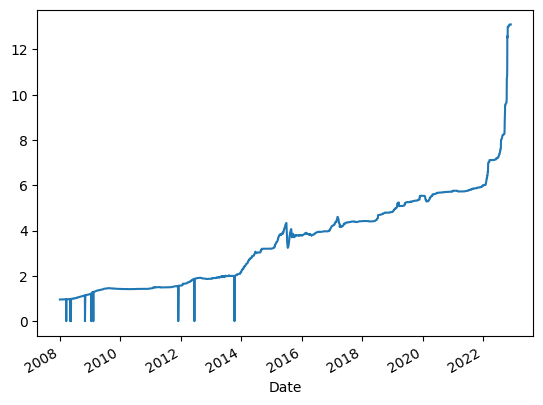

In [8]:
df[Y_COL].plot()

In [9]:
df.drop(columns=['NonFoodInflation', 'FoodInflation', 'Selling', 'MidRate',
        'Imports', 'Exports', 'InterbankWeightedAvg', 'MPR', 'T-bill-91'], inplace=True)

In [10]:
# df.drop(columns=['Selling'], inplace=True)
# df.drop(columns=['Selling', 'Buying'], inplace=True)

In [11]:
# Fix exact-zero targets → NaN → interpolate (common data issue)
if (df[Y_COL] == 0).any():
    df.loc[df[Y_COL] == 0, Y_COL] = np.nan
    df[Y_COL] = df[Y_COL].interpolate(method="time").ffill().bfill()

# Choose predictors: macro + commodities; drop near-duplicates of target
# drop_cols = {"Buying", "MidRate", "Selling"}
# drop_cols = {"MidRate"}
drop_cols = {Y_COL}
exog_cols = [c for c in df.columns if c not in drop_cols]
num_cols = [c for c in exog_cols if np.issubdtype(
    df[c].dropna().dtype, np.number)]

work = df[[Y_COL] + num_cols].copy()

In [12]:
FEATURES = df.columns.tolist()

In [13]:
# # Interest Rate Parity (IRP)
# df['InterestRateDifferential'] = df['GhInterestRate'] - df['USInterestRate']
# FEATURES.append('InterestRateDifferential')

# # Purchasing Power Parity (PPP)
# df['InflationDifferential'] = df['GhInflationRate'] - df['USInflationRate']
# FEATURES.append('InflationDifferential')

In [14]:
# C. Time-based Features (Cyclicality)
# df['DayOfWeek'] = df.index.dayofweek
# df['DayOfYear'] = df.index.dayofyear
# # Binary feature for structural month-end flows
# df['IsMonthEnd'] = df.index.is_month_end.astype(int)
# FEATURES.extend(['DayOfWeek', 'DayOfYear', 'IsMonthEnd'])

In [15]:
# QUARTERLY_SHIFT = 60
# df['GhGDPQoQGrowth'] = (
#     df['GhGDP'] / df['GhGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
# df['USGDPQoQGrowth'] = (
#     df['USGDP'] / df['USGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
# FEATURES.extend(['GhGDPQoQGrowth', 'USGDPQoQGrowth'])

In [16]:
work = df.dropna(subset=[Y_COL] + FEATURES)

In [17]:
# ---------- 2) RESAMPLE TO WEEKLY & BUILD Δ FEATURES ----------
wk = work.resample("W-FRI").last().dropna(how="all")

In [18]:
wk["log_Buying"] = np.log(wk[Y_COL])
wk["y"] = wk["log_Buying"].diff()  # target: Δlog(Buying)

# Exogenous deltas (Δlog if strictly positive; else simple diff)
X_delta = pd.DataFrame(index=wk.index)
for c in num_cols:
    s = wk[c]
    if is_strictly_positive(s):
        X_delta[c + "_dlog"] = np.log(s).diff()
    else:
        X_delta[c + "_diff"] = s.diff()

data = pd.concat([wk[["y"]], X_delta], axis=1).dropna()

In [19]:
# ---------- 3) FEATURE ENGINEERING FOR XGB ----------
ml_df = make_ml_features(data, y_col="y", max_lag=4,
                         roll_windows=(4, 8)).dropna()

In [20]:
# Time split
n = len(ml_df)
test_size = max(int(TEST_FRACTION * n), MIN_TEST_WEEKS)
train_df = ml_df.iloc[:-test_size].copy()
test_df = ml_df.iloc[-test_size:].copy()
y_train, X_train = train_df["y"], train_df.drop(columns=["y"])
y_test,  X_test = test_df["y"],  test_df.drop(columns=["y"])

In [21]:
xgb_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("xgb", XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=4
    ))
])

In [22]:
# Rolling-origin CV on train
tscv = TimeSeriesSplit(n_splits=5)
cv_preds = np.empty_like(y_train.values)
cv_preds[:] = np.nan
for tr_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    xgb_pipe.fit(X_tr, y_tr)
    cv_preds[val_idx] = xgb_pipe.predict(X_val)

In [23]:
mask = ~np.isnan(cv_preds)
cv_metrics = evaluate_metrics(y_train.values[mask], cv_preds[mask])

# Fit final on full train, eval on test
xgb_pipe.fit(X_train, y_train)
test_pred = xgb_pipe.predict(X_test)
test_metrics = evaluate_metrics(y_test.values, test_pred)
# test_metrics = evaluate_metrics(y_test.values, test_pred)

In [24]:
metrics_df = pd.DataFrame([
    {"Model": "XGBoost (lags+rolls)", "Split": "CV",   **
     {k: round(v, 6) for k, v in cv_metrics.items()}},
    {"Model": "XGBoost (lags+rolls)", "Split": "TEST", **
     {k: round(v, 6) for k, v in test_metrics.items()}},
])
metrics_df

,Model,Split,MAE,RMSE,R2
0,XGBoost (lags+rolls),CV,0.00424,0.011003,0.240538
1,XGBoost (lags+rolls),TEST,0.00479,0.016903,0.301631


In [25]:
# ---------- 5) SAVE METRICS, PREDS, FEATURE IMPORTANCES ----------


# metrics_path = os.path.join(OUT_DIR, "xgb_fx_metrics.csv")
# metrics_df.to_csv(metrics_path, index=False)

preds_df = pd.DataFrame({
    "Date": y_test.index,
    "y_true_dlog": y_test.values,
    "y_pred_dlog": test_pred
}).set_index("Date")

# preds_path = os.path.join(OUT_DIR, "xgb_fx_predictions.csv")
# preds_df.to_csv(preds_path)

xgb_model = xgb_pipe.named_steps["xgb"]
fi = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_model.feature_importances_}) \
       .sort_values("Importance", ascending=False).reset_index(drop=True)
fi_top = fi.head(min(30, len(fi)))
# fi_path = os.path.join(OUT_DIR, "xgb_feature_importances_top30.csv")
# fi_top.to_csv(fi_path, index=False)

In [26]:
fi_top

,Feature,Importance
0,FXDeposits_dlog_lag1,0.237903
1,FXDeposits_dlog,0.103224
2,y_rollmean_4,0.062611
3,y_rollstd_8,0.045870
4,PrivateSectorCredit_dlog,0.044683
5,y_rollstd_4,0.038484
6,y_rollmean_8,0.034783
7,y_lag1,0.032220
8,y_lag3,0.028753
9,y_lag4,0.025853


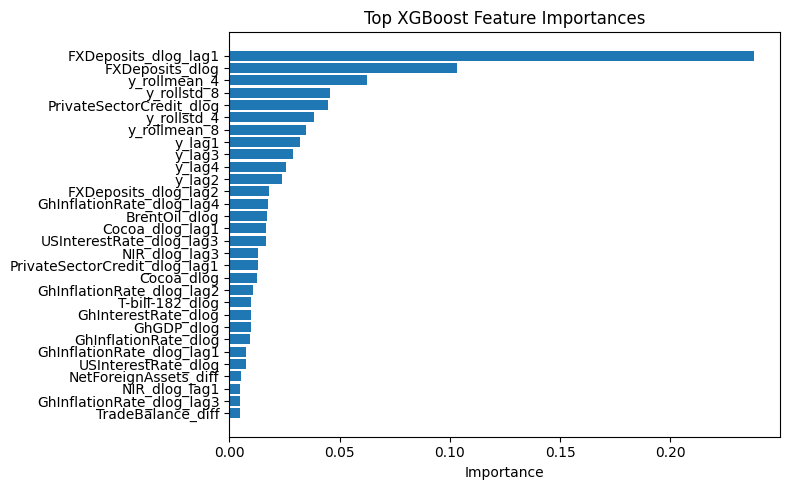

In [27]:
plt.figure(figsize=(8,5))
plt.barh(fi_top["Feature"], fi_top["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top XGBoost Feature Importances")
plt.tight_layout()
plt.savefig('plots/xgb/xgb_feature_importance.png')
plt.show()

In [28]:
# ---------- 6) PLOTS ----------
# Reconstruct levels for visualization (optional)
pre_test_idx = wk.index[wk.index < y_test.index[0]]
assert len(pre_test_idx) > 0, "Need at least 1 observation before test start."
anchor_log = wk.loc[pre_test_idx[-1], "log_Buying"]

true_level = invert_dlog_to_level(
    pd.Series(y_test.values, index=y_test.index), anchor_log)
xgb_level = invert_dlog_to_level(
    pd.Series(test_pred,  index=y_test.index), anchor_log)
rw_level = invert_dlog_to_level(
    pd.Series(np.zeros_like(y_test.values), index=y_test.index), anchor_log)

In [29]:
true_vs_pred_df = pd.DataFrame({
    "Date": y_test.index,
    "Actual_Buying_Level": true_level.values,
    "XGBoost_Predicted_Level": xgb_level.values,
    "Random_Walk_Level": rw_level.values
}).set_index("Date")

In [30]:
true_vs_pred_df.to_csv('xgb.csv')

In [31]:
true_vs_pred_df.head()

,Actual_Buying_Level,XGBoost_Predicted_Level,Random_Walk_Level
Date,,,
2019-12-27,5.5360,5.544609,5.5368
2020-01-03,5.5314,5.536551,5.5368
2020-01-10,5.5335,5.534317,5.5368
2020-01-17,5.5314,5.535257,5.5368
2020-01-24,5.5239,5.534384,5.5368


In [32]:
true_vs_pred_df.tail()

,Actual_Buying_Level,XGBoost_Predicted_Level,Random_Walk_Level
Date,,,
2022-11-04,13.0012,9.339513,5.5368
2022-11-11,13.0694,9.414652,5.5368
2022-11-18,13.0990,9.519982,5.5368
2022-11-25,13.0985,9.711535,5.5368
2022-12-02,13.0973,9.634313,5.5368


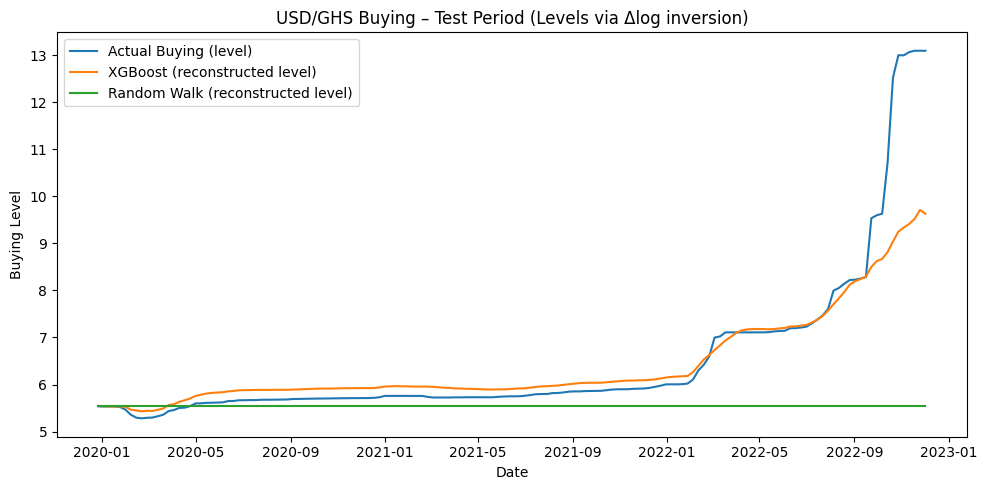

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(true_vs_pred_df.index, true_vs_pred_df["Actual_Buying_Level"], label="Actual Buying (level)")
plt.plot(true_vs_pred_df.index, true_vs_pred_df["XGBoost_Predicted_Level"], label="XGBoost (reconstructed level)")
plt.plot(true_vs_pred_df.index, true_vs_pred_df["Random_Walk_Level"], label="Random Walk (reconstructed level)")
plt.title("USD/GHS Buying – Test Period (Levels via Δlog inversion)")
plt.xlabel("Date")
plt.ylabel("Buying Level")
plt.legend()
plt.tight_layout()
plt.savefig('plots/xgb/xgb_vs_random_walk_actual_vs_predicted.png')
plt.show()

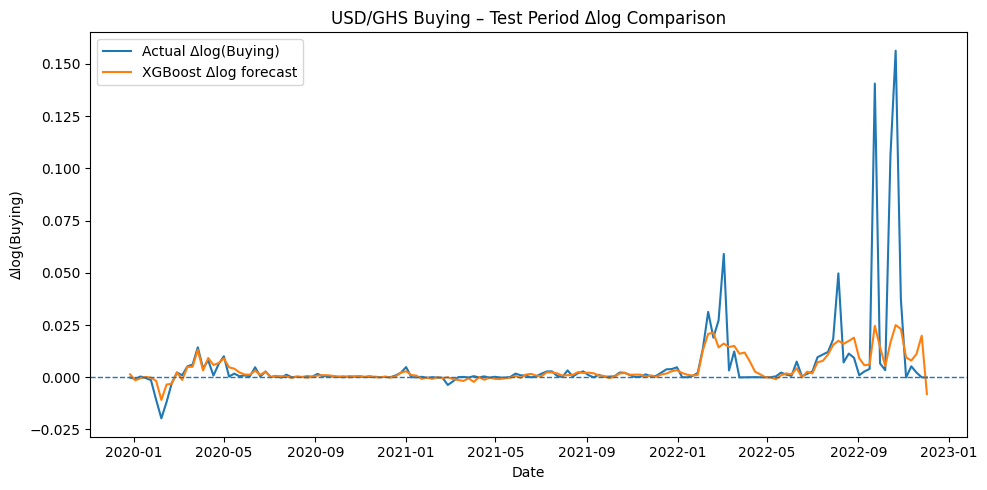

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label="Actual Δlog(Buying)")
plt.plot(y_test.index, test_pred,     label="XGBoost Δlog forecast")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title("USD/GHS Buying – Test Period Δlog Comparison")
plt.xlabel("Date")
plt.ylabel("Δlog(Buying)")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# Error metrics for test predictions (in delta log space)
mae = mean_absolute_error(y_test, test_pred)
rmse = root_mean_squared_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")


Test MAE: 0.004790138910441429
Test RMSE: 0.016902943904841546
Test R^2: 0.30163119397812466


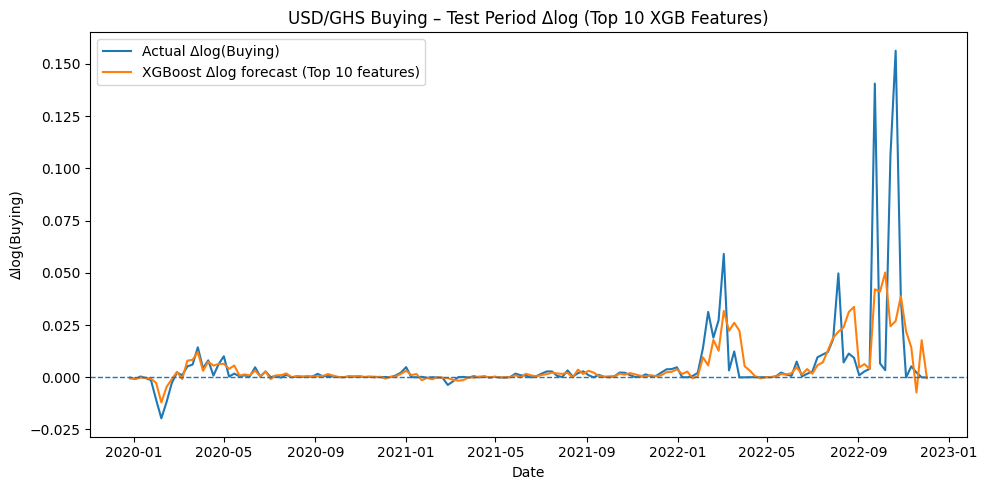

In [36]:
import pandas as pd

# Get feature importance from fitted model
xgb_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values("Importance", ascending=False)

top_n = 10
top_features = xgb_importances['Feature'].head(top_n).tolist()

# Subset data to use only the most important features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Refit XGB model on top important features
from xgboost import XGBRegressor

xgb_top = XGBRegressor(n_estimators=100, random_state=42)
xgb_top.fit(X_train_top, y_train)

# Predict on test set using only important features
y_test_pred_top = xgb_top.predict(X_test_top)

# Plot actual vs predicted (Δlog buying) using most important XGB features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label="Actual Δlog(Buying)")
plt.plot(y_test.index, y_test_pred_top, label=f"XGBoost Δlog forecast (Top {top_n} features)")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title(f"USD/GHS Buying – Test Period Δlog (Top {top_n} XGB Features)")
plt.xlabel("Date")
plt.ylabel("Δlog(Buying)")
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics for test set predictions using only top important features
mae_top = mean_absolute_error(y_test, y_test_pred_top)
rmse_top = root_mean_squared_error(y_test, y_test_pred_top)
r2_top = r2_score(y_test, y_test_pred_top)
mape_top = (np.abs((y_test - y_test_pred_top) / y_test).mean()) * 100

print(f"Test Metrics using Top {top_n} XGB Features:")
print(f"MAE:  {mae_top:.6f}")
print(f"RMSE: {rmse_top:.6f}")
print(f"R2:   {r2_top:.6f}")
print(f"MAPE: {mape_top:.2f}%")


Test Metrics using Top 10 XGB Features:
MAE:  0.005345
RMSE: 0.016648
R2:   0.322551
MAPE: inf%


In [38]:
# LSTM using same engineered features as for xgb

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# Select the same features as in XGB model
feature_cols = X_train.columns  # assumes X_train/X_test as in XGB part
target_col = y_train.name

# Scale features (LSTM works better if data is scaled)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

# Reshape for LSTM: [samples, timesteps, features]
# We'll do single-step prediction (many-to-one), so timesteps=1
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM model definition
lstm_model = keras.Sequential([
    layers.LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit model
history = lstm_model.fit(
    X_train_lstm, y_train_scaled,
    validation_data=(X_test_lstm, y_test_scaled),
    epochs=50, batch_size=16, verbose=2
)

# Predict and inverse transform
y_pred_scaled = lstm_model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

2025-10-21 08:32:11.606158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
39/39 - 3s - 66ms/step - loss: 0.9605 - mae: 0.4439 - val_loss: 2.8401 - val_mae: 0.5882
Epoch 2/50
39/39 - 0s - 4ms/step - loss: 0.8288 - mae: 0.3851 - val_loss: 2.5760 - val_mae: 0.5699
Epoch 3/50
39/39 - 0s - 4ms/step - loss: 0.7212 - mae: 0.3427 - val_loss: 2.4319 - val_mae: 0.5546
Epoch 4/50
39/39 - 0s - 3ms/step - loss: 0.6113 - mae: 0.3170 - val_loss: 2.3047 - val_mae: 0.5576
Epoch 5/50
39/39 - 0s - 3ms/step - loss: 0.5038 - mae: 0.2939 - val_loss: 2.2863 - val_mae: 0.5616
Epoch 6/50
39/39 - 0s - 4ms/step - loss: 0.3948 - mae: 0.2650 - val_loss: 2.2457 - val_mae: 0.5716
Epoch 7/50
39/39 - 0s - 4ms/step - loss: 0.2905 - mae: 0.2343 - val_loss: 2.3222 - val_mae: 0.5802
Epoch 8/50
39/39 - 0s - 5ms/step - loss: 0.2054 - mae: 0.2092 - val_loss: 2.2953 - val_mae: 0.6039
Epoch 9/50
39/39 - 0s - 5ms/step - loss: 0.1331 - mae: 0.1819 - val_loss: 2.3311 - val_mae: 0.6173
Epoch 10/50
39/39 - 0s - 4ms/step - loss: 0.0875 - mae: 0.1593 - val_loss: 2.3576 - val_mae: 0.6349
Epoch 11

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_lstm = mean_absolute_error(y_test, y_pred)
rmse_lstm = root_mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print(f"LSTM Test MAE: {mae_lstm}")
print(f"LSTM Test RMSE: {rmse_lstm}")
print(f"LSTM Test R^2: {r2_lstm}")

LSTM Test MAE: 0.007229455887774027
LSTM Test RMSE: 0.017343663312457482
LSTM Test R^2: 0.2647385432299568


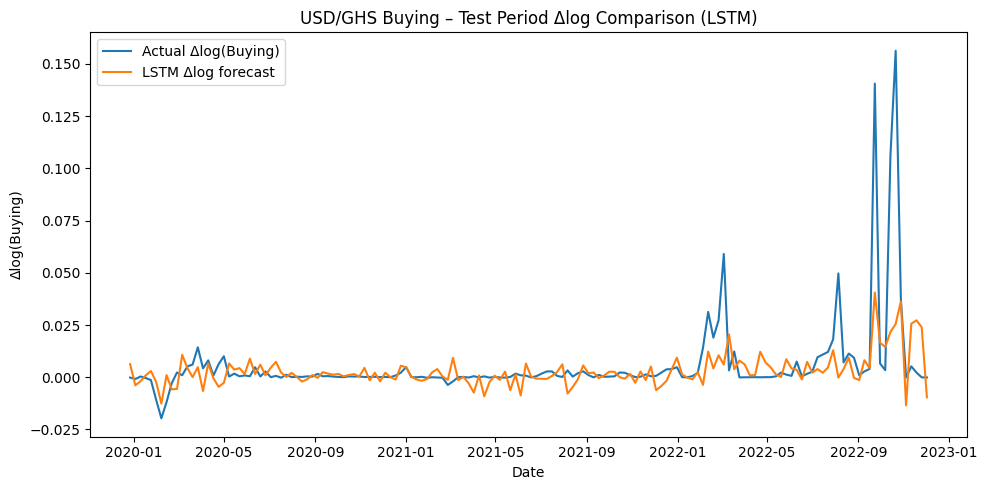

In [40]:
# Evaluate


# Plot actual vs predicted (delta log space)
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label="Actual Δlog(Buying)")
plt.plot(y_test.index, y_pred, label="LSTM Δlog forecast")
plt.title("USD/GHS Buying – Test Period Δlog Comparison (LSTM)")
plt.xlabel("Date")
plt.ylabel("Δlog(Buying)")
plt.legend()
plt.tight_layout()
plt.show()

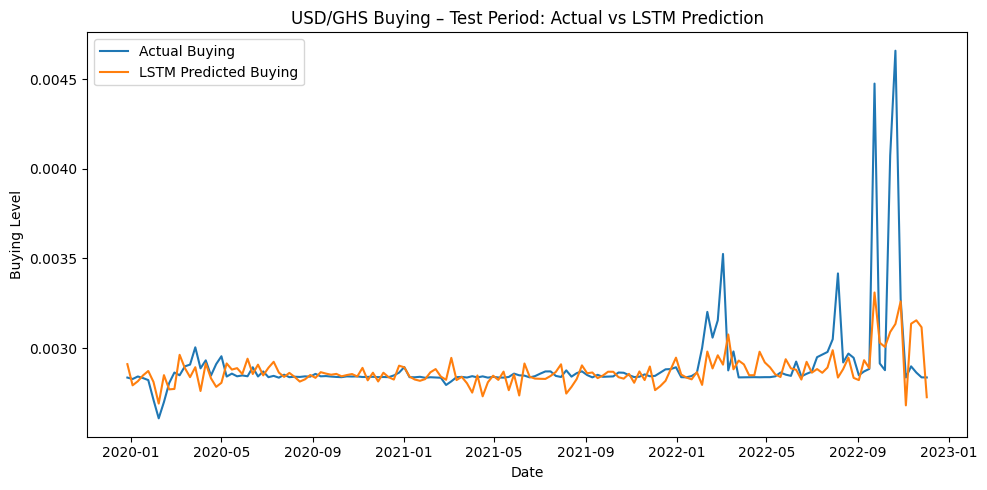

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, scaler_y.inverse_transform(y_test.values.reshape(-1, 1)), label="Actual Buying")
plt.plot(y_test.index, scaler_y.inverse_transform(y_pred.reshape(-1, 1)), label="LSTM Predicted Buying")
plt.title("USD/GHS Buying – Test Period: Actual vs LSTM Prediction")
plt.xlabel("Date")
plt.ylabel("Buying Level")
plt.legend()
plt.tight_layout()
plt.show()


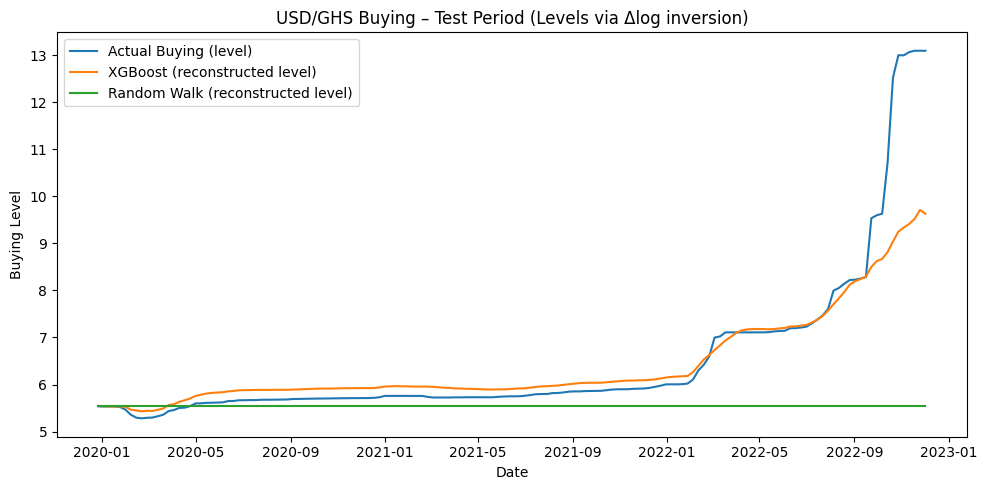

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(true_level.index, true_level.values, label="Actual Buying (level)")
plt.plot(xgb_level.index, xgb_level.values,
         label="XGBoost (reconstructed level)")
plt.plot(rw_level.index,  rw_level.values,
         label="Random Walk (reconstructed level)")
plt.title("USD/GHS Buying – Test Period (Levels via Δlog inversion)")
plt.xlabel("Date")
plt.ylabel("Buying Level")
plt.legend()
plt.tight_layout()
plt.savefig('plots/xgb/xgb_vs_random_walk_actual_vs_predicted.png')
plt.show()